In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Thu Jan 11 23:00:49 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   26C    P8    17W / 230W |      6MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_min_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-14/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 116816
-rw-rw-r-- 1 scpark scpark   376004  1월 11 23:00 events.out.tfevents.1704981518.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37973949  1월 11 22:58 save_0
-rw-rw-r-- 1 scpark scpark  1994436  1월 11 22:39 events.out.tfevents.1704979673.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37979741  1월 11 22:38 save_20000
-rw-rw-r-- 1 scpark scpark 37979741  1월 11 22:33 save_10000
-rw-rw-r-- 1 scpark scpark   734660  1월 11 22:27 events.out.tfevents.1704979357.GPUSVR01
-rw-rw-r-- 1 scpark scpark  2565874  1월 11 22:22 events.out.tfevents.1704978421.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


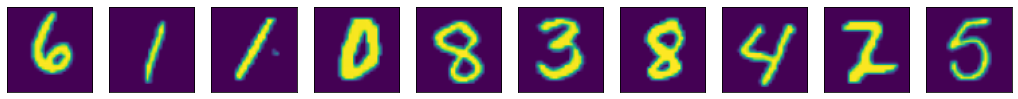

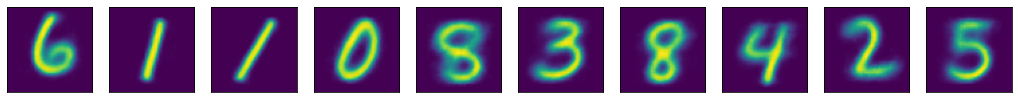

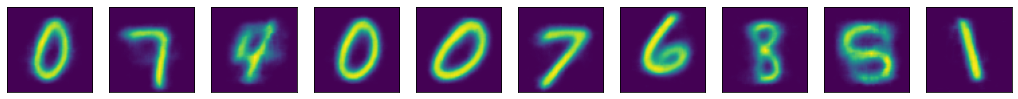

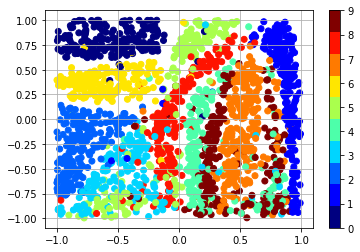

31001
lse_loss 0.017618127167224884
recon_loss 0.10381995141506195
31002
lse_loss 0.019705848768353462
recon_loss 0.10805176198482513
31003
lse_loss 0.022418268024921417
recon_loss 0.11929196119308472
31004
lse_loss 0.020167971029877663
recon_loss 0.10713779181241989
31005
lse_loss 0.017935961484909058
recon_loss 0.11193730682134628
31006
lse_loss 0.02531353011727333
recon_loss 0.1057547926902771
31007
lse_loss 0.021052148193120956
recon_loss 0.09594057500362396
31008
lse_loss 0.021602444350719452
recon_loss 0.10659375041723251
31009
lse_loss 0.02474622242152691
recon_loss 0.09763242304325104
31010
lse_loss 0.02199828065931797
recon_loss 0.10375696420669556
31011
lse_loss 0.02026098035275936
recon_loss 0.11479424685239792
31012
lse_loss 0.024205565452575684
recon_loss 0.11447300016880035
31013
lse_loss 0.020279673859477043
recon_loss 0.11397047340869904
31014
lse_loss 0.026133306324481964
recon_loss 0.1272927224636078
31015
lse_loss 0.021403450518846512
recon_loss 0.10722948610782623
3

31127
lse_loss 0.021802430972456932
recon_loss 0.09175235033035278
31128
lse_loss 0.02207133360207081
recon_loss 0.11666588485240936
31129
lse_loss 0.0225876085460186
recon_loss 0.0991004928946495
31130
lse_loss 0.020941508933901787
recon_loss 0.1144586056470871
31131
lse_loss 0.018716096878051758
recon_loss 0.10755743086338043
31132
lse_loss 0.01989562250673771
recon_loss 0.09953425824642181
31133
lse_loss 0.024361418560147285
recon_loss 0.0891890674829483
31134
lse_loss 0.019962329417467117
recon_loss 0.10605733841657639
31135
lse_loss 0.023743480443954468
recon_loss 0.09988396614789963
31136
lse_loss 0.02287960611283779
recon_loss 0.09986206144094467
31137
lse_loss 0.017215296626091003
recon_loss 0.10444466769695282
31138
lse_loss 0.0218281801789999
recon_loss 0.12268996238708496
31139
lse_loss 0.0207219235599041
recon_loss 0.10591384768486023
31140
lse_loss 0.018999991938471794
recon_loss 0.10936342179775238
31141
lse_loss 0.021260246634483337
recon_loss 0.10833512246608734
31142
l

31253
lse_loss 0.02401907369494438
recon_loss 0.09674730896949768
31254
lse_loss 0.019255846738815308
recon_loss 0.10985680669546127
31255
lse_loss 0.019374608993530273
recon_loss 0.10108062624931335
31256
lse_loss 0.022459866479039192
recon_loss 0.09509699046611786
31257
lse_loss 0.018722079694271088
recon_loss 0.09720977395772934
31258
lse_loss 0.02942846529185772
recon_loss 0.10911118984222412
31259
lse_loss 0.018900565803050995
recon_loss 0.11123186349868774
31260
lse_loss 0.023336073383688927
recon_loss 0.09559839963912964
31261
lse_loss 0.021822374314069748
recon_loss 0.11061598360538483
31262
lse_loss 0.026521243155002594
recon_loss 0.1012934073805809
31263
lse_loss 0.0206336360424757
recon_loss 0.10826443135738373
31264
lse_loss 0.023554768413305283
recon_loss 0.10686826705932617
31265
lse_loss 0.020055660977959633
recon_loss 0.10740797221660614
31266
lse_loss 0.019005101174116135
recon_loss 0.11987912654876709
31267
lse_loss 0.022015994414687157
recon_loss 0.09747910499572754


31379
lse_loss 0.018430205062031746
recon_loss 0.09848088026046753
31380
lse_loss 0.02302164025604725
recon_loss 0.10737481713294983
31381
lse_loss 0.02191927097737789
recon_loss 0.10568201541900635
31382
lse_loss 0.02355859987437725
recon_loss 0.10847368091344833
31383
lse_loss 0.021634787321090698
recon_loss 0.11212509125471115
31384
lse_loss 0.02126500941812992
recon_loss 0.11270596832036972
31385
lse_loss 0.024096151813864708
recon_loss 0.1157001256942749
31386
lse_loss 0.022478414699435234
recon_loss 0.10695213079452515
31387
lse_loss 0.020799942314624786
recon_loss 0.09894496202468872
31388
lse_loss 0.020832793787121773
recon_loss 0.10612137615680695
31389
lse_loss 0.024999501183629036
recon_loss 0.10520216077566147
31390
lse_loss 0.027070622891187668
recon_loss 0.1118452176451683
31391
lse_loss 0.02281367965042591
recon_loss 0.09819786250591278
31392
lse_loss 0.022976329550147057
recon_loss 0.09752212464809418
31393
lse_loss 0.020273635163903236
recon_loss 0.11325585842132568
31

31505
lse_loss 0.019324108958244324
recon_loss 0.10794410109519958
31506
lse_loss 0.019176194444298744
recon_loss 0.10774947702884674
31507
lse_loss 0.021643444895744324
recon_loss 0.11061032116413116
31508
lse_loss 0.022755548357963562
recon_loss 0.11691944301128387
31509
lse_loss 0.0340721532702446
recon_loss 0.10539889335632324
31510
lse_loss 0.020245259627699852
recon_loss 0.10365154594182968
31511
lse_loss 0.02166849561035633
recon_loss 0.10677196085453033
31512
lse_loss 0.017960593104362488
recon_loss 0.10988475382328033
31513
lse_loss 0.020871032029390335
recon_loss 0.10132541507482529
31514
lse_loss 0.01920676790177822
recon_loss 0.11354097723960876
31515
lse_loss 0.02216731384396553
recon_loss 0.11790653318166733
31516
lse_loss 0.02390112727880478
recon_loss 0.1058383584022522
31517
lse_loss 0.021261364221572876
recon_loss 0.10654985904693604
31518
lse_loss 0.01855514757335186
recon_loss 0.10556264221668243
31519
lse_loss 0.021235808730125427
recon_loss 0.09958480298519135
315

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000, sigma=1e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        

In [ ]:
torch.__version__